In [1]:
import pandas as pd

# Load the data

In [2]:
df=pd.read_csv('Titanic-Dataset.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# The PassengerId, Name, and Ticket columns are typically not needed for predicting survival, as they mainly serve as identifiers,So drop them

In [3]:
df=df.drop(['PassengerId','Name','Ticket'],axis=1)

# Data Preprocessing

In [4]:
# check for null values
df.isnull().mean()

Survived    0.000000
Pclass      0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [6]:
# as 77% of cabin colume is empty so dropping it
df=df.drop('Cabin',axis=1)

In [8]:
## Using imputers to remove null value of age and embarked
from sklearn.impute import SimpleImputer
age_imputer = SimpleImputer(strategy='median')
df['Age'] = age_imputer.fit_transform(df[['Age']])

embarked_imputer = SimpleImputer(strategy='most_frequent')
df['Embarked'] = embarked_imputer.fit_transform(df[['Embarked']]).ravel()



In [9]:
df.isnull().mean()

Survived    0.0
Pclass      0.0
Sex         0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
Embarked    0.0
dtype: float64

In [12]:
#check for duplicates data
df.duplicated().sum()
# we need to drop te duplicates values
df=df.drop_duplicates()

## Feature Encoding

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
df['Sex'] = label_encoder.fit_transform(df['Sex'])

C:\Users\Dell\AppData\Local\Temp\ipykernel_17980\2499815178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Embarked'] = label_encoder.fit_transform(df['Embarked'])
C:\Users\Dell\AppData\Local\Temp\ipykernel_17980\2499815178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = label_encoder.fit_transform(df['Sex'])


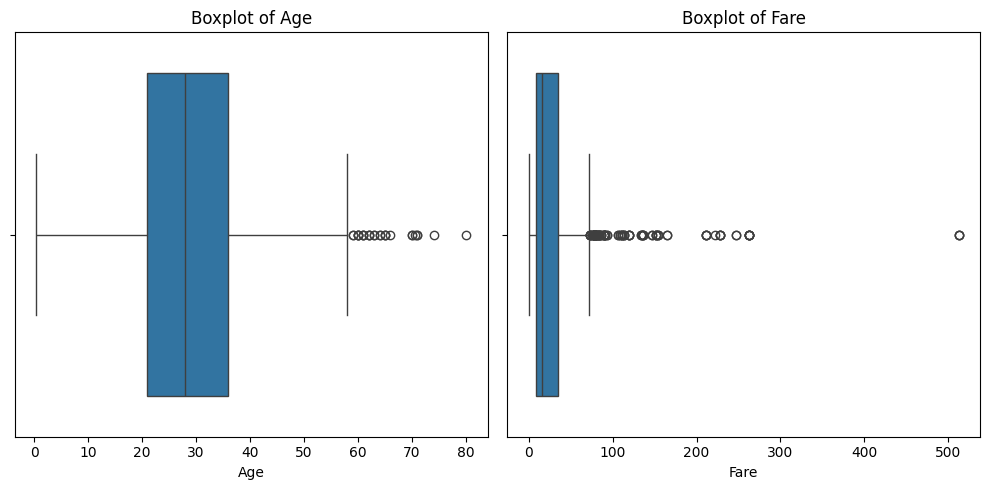

In [14]:
# Remove Outliers:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Fare'])
plt.title('Boxplot of Fare')

plt.tight_layout()
plt.show()

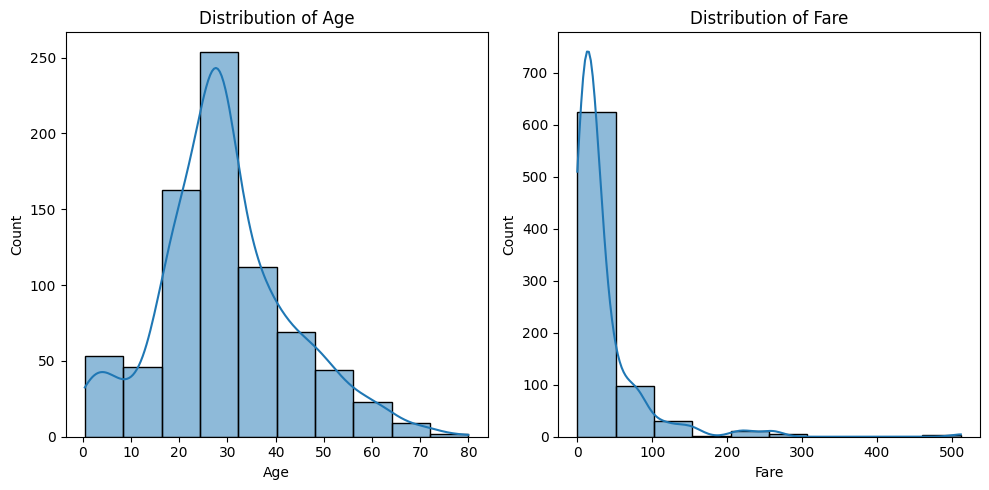

In [15]:
# checking the distribution of data to remove outliers
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Age'], kde=True, bins=10)
plt.title('Distribution of Age')

plt.subplot(1, 2, 2)
sns.histplot(df['Fare'], kde=True, bins=10)
plt.title('Distribution of Fare')

plt.tight_layout()
plt.show()

For the Age distribution:
-It appears to follow an approximately normal distribution, but with some right skew
The peak is around age 30-35
There's a longer tail extending to older ages (60-80)
This distribution shows characteristics of a slightly right-skewed normal distribution

For the Fare distribution:

This is clearly NOT normally distributed
It's heavily right-skewed (positively skewed)

In [16]:
from scipy import stats

In [17]:
import numpy as np
def cap_age_zscore(df, threshold=3):
    mean = df['Age'].mean()
    std = df['Age'].std()
    
    upper_cap = mean + threshold * std
    lower_cap = mean - threshold * std

    df.loc[df['Age'] > upper_cap, 'Age'] = upper_cap
    df.loc[df['Age'] < lower_cap, 'Age'] = lower_cap
    
    return df 
def cap_fare_iqr(df, multiplier=1.5):
    Q1 = df['Fare'].quantile(0.25)
    Q3 = df['Fare'].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_bound = Q3 + multiplier * IQR
    lower_bound = Q1 - multiplier * IQR
    
    df.loc[df['Fare'] > upper_bound, 'Fare'] = upper_bound
    df.loc[df['Fare'] < lower_bound, 'Fare'] = lower_bound
    
    return df 

age_min_original, age_max_original = df['Age'].min(), df['Age'].max()
fare_min_original, fare_max_original = df['Fare'].min(), df['Fare'].max()
cap_age_zscore(df, threshold=3)
cap_fare_iqr(df, multiplier=1.5)

print("Age - Original vs Capped Statistics:")
print(f"Original min: {age_min_original}, max: {age_max_original}")
print(f"Capped min: {df['Age'].min()}, max: {df['Age'].max()}")

print("\nFare - Original vs Capped Statistics:")
print(f"Original min: {fare_min_original}, max: {fare_max_original}")
print(f"Capped min: {df['Fare'].min()}, max: {df['Fare'].max()}")

Age - Original vs Capped Statistics:
Original min: 0.42, max: 80.0
Capped min: 0.42, max: 70.88026272524246

Fare - Original vs Capped Statistics:
Original min: 0.0, max: 512.3292
Capped min: 0.0, max: 73.41975000000001


# Feature selection

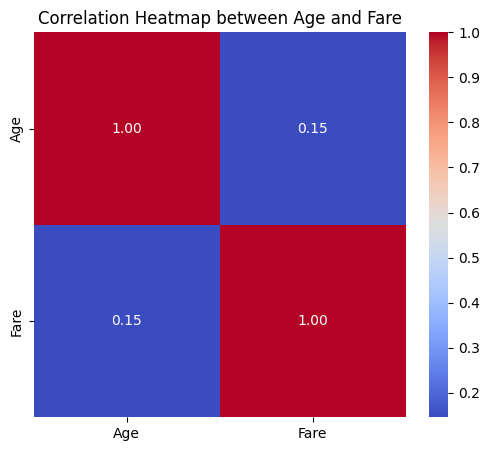

In [18]:
#Feature selection
# for numerical data
correlation_matrix = df[['Age', 'Fare']].corr()

# Step 2: Plot correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between Age and Fare')
plt.show()
   

In [19]:
# for categorical columns
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [20]:
from scipy.stats import chi2_contingency

categorical_vars = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

chi2_results = {}
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['Survived'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    chi2_results[var] = {
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof
    }
results_df = pd.DataFrame.from_dict(chi2_results, orient='index')
results_df = results_df.sort_values(by='p_value')
print(results_df)

# Select variables with significant relationship (p < 0.05)
significant_vars = results_df[results_df['p_value'] < 0.05].index.tolist()
print("\nCategorical variables significantly associated with Survival:")
print(significant_vars)

                chi2       p_value  dof
Sex       204.287302  2.422674e-46    1
Pclass     86.970860  1.301721e-19    2
Embarked   22.669200  1.195214e-05    2
SibSp      24.313644  4.572282e-04    6
Parch      22.587097  9.472461e-04    6

Categorical variables significantly associated with Survival:
['Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch']


In [23]:
#Split the data int
X=df.drop('Survived',axis=1)
y=df['Survived']

# ML Model


Logistic Regression Performance Metrics:
Accuracy: 0.7806
Precision: 0.7241
Recall: 0.7000
F1 Score: 0.7119

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        95
           1       0.72      0.70      0.71        60

    accuracy                           0.78       155
   macro avg       0.77      0.77      0.77       155
weighted avg       0.78      0.78      0.78       155



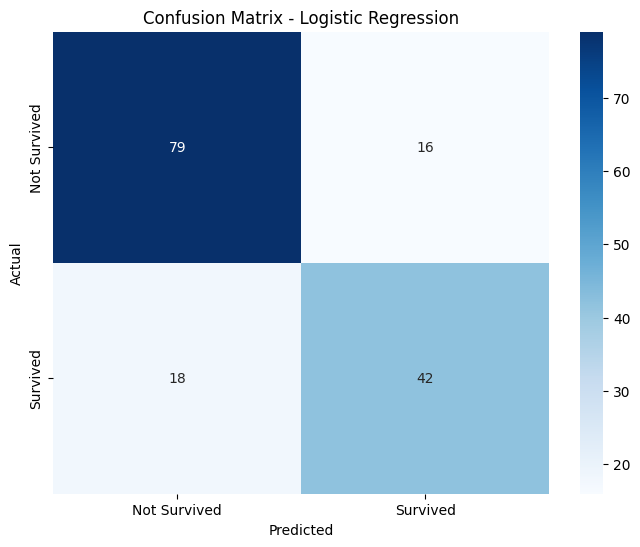

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nLogistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.savefig('logistic_regression_confusion_matrix.png')
plt.show()



Random Forest Performance Metrics:
Accuracy: 0.7742
Precision: 0.7358
Recall: 0.6500
F1 Score: 0.6903

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        95
           1       0.74      0.65      0.69        60

    accuracy                           0.77       155
   macro avg       0.76      0.75      0.76       155
weighted avg       0.77      0.77      0.77       155



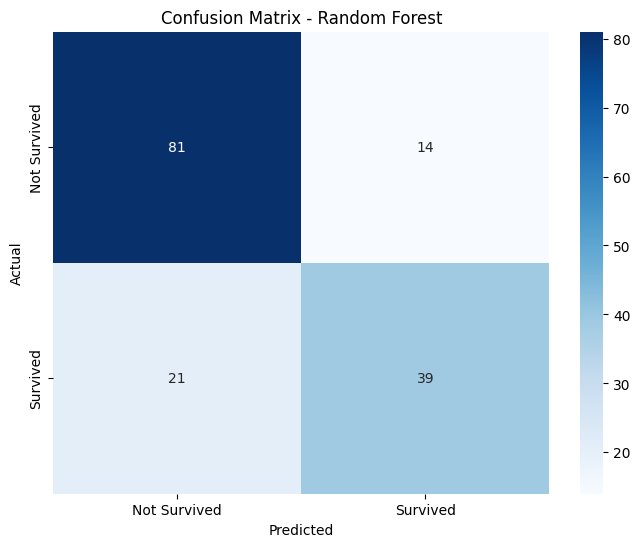

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)


print("\nRandom Forest Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.savefig('random_forest_confusion_matrix.png')
plt.show()




---- Training Neural Network Model ----


C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.5082 - loss: 0.7388 - val_accuracy: 0.5887 - val_loss: 0.7031
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5933 - loss: 0.6935 - val_accuracy: 0.6048 - val_loss: 0.6663
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6267 - loss: 0.6453 - val_accuracy: 0.6774 - val_loss: 0.6410
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7020 - loss: 0.6157 - val_accuracy: 0.7177 - val_loss: 0.6233
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7327 - loss: 0.5711 - val_accuracy: 0.7258 - val_loss: 0.6114
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7398 - loss: 0.5464 - val_accuracy: 0.7258 - val_loss: 0.6030
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7362 - loss: 0.5477 - val_accuracy: 0.7500 - val_loss: 0.5974
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7505 - loss: 0.5319 - val_accuracy: 0.

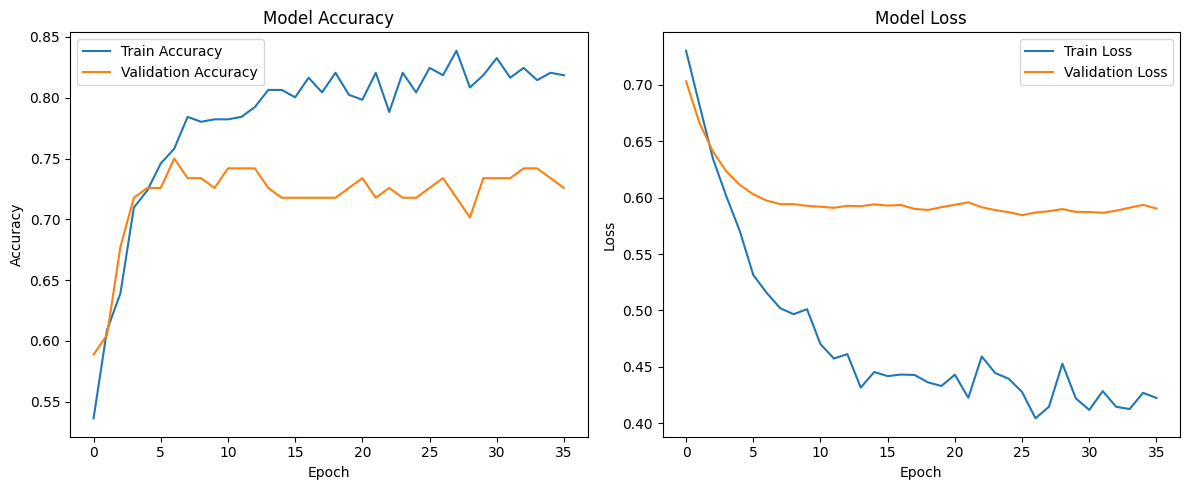

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Neural Network Performance Metrics:
Accuracy: 0.7742
Precision: 0.7119
Recall: 0.7000
F1 Score: 0.7059

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82        95
           1       0.71      0.70      0.71        60

    accuracy                           0.77       155
   macro avg       0.76      0.76      0.76       155
weighted avg       0.77      0.77      0.77       155



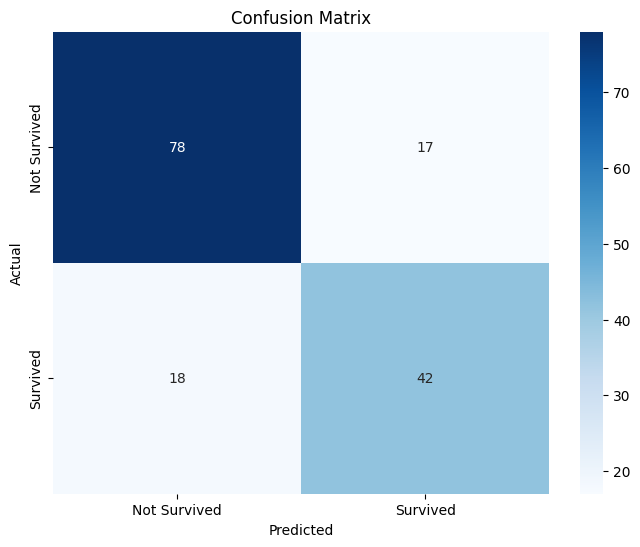

In [27]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n---- Training Neural Network Model ----")

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model and save training history
history = model.fit(
    X_train_scaled, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('nn_training_history.png')
plt.show()

# Evaluate the model on test data
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nNeural Network Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('nn_confusion_matrix.png')
plt.show()


# Conclusion
Logistic Regression is the best model for our dataset, outperforming Random Forest and Neural Network. It has the highest accuracy (0.7806) and F1 score (0.7119), offering the best balance between precision (0.7241) and recall (0.7000). While Random Forest has higher precision, Logistic Regression's better recall makes it more effective at identifying positive cases. Additionally, Logistic Regression is simpler and more interpretable, making it easier to deploy and explain. Therefore, Logistic Regression is the optimal choice for this dataset.